In [58]:
import sys
import os
import platform
import importlib
import glob

import numpy as np
import pandas as pd
import netCDF4
import datetime

if platform.system() == 'Darwin':  # macOS
    base_FP = '/Users/hyunglokkim/Insync/hkim@geol.sc.edu/Google_Drive'
    cpuserver_data_FP = '/Users/hyunglokkim/cpuserver_data'
else:
    base_FP = '/data'
    cpuserver_data_FP = '/data'
sys.path.append(base_FP + '/python_modules')

#hydroAI libs
import hydroAI.SMAP as hSMAP
import hydroAI.SMOS_IC as hSMOS_IC
import hydroAI.ASCAT_TUW as hASCAT_TUW
import hydroAI.Plot as Plot
import hydroAI.Data as Data
importlib.reload(hSMAP);
importlib.reload(hSMOS_IC);
importlib.reload(hASCAT_TUW);
importlib.reload(Plot);
importlib.reload(Data);

# Ignore runtime warnings
import warnings
warnings.filterwarnings("ignore")

# Define your directory where to save nc files
nc_save_dir = cpuserver_data_FP + '/extracted_nc'

## 1. Import and Save SMAPL3 or SMAPL3_E SM data

In [111]:
# Usage example
mission = 'SMAP'
mission_product = 'SPL3SMP.008'
#mission_product = 'SPL3SMP_E.005'
year = 2015
directory = os.path.join(cpuserver_data_FP, mission, mission_product)
file_list, data_doy = hSMAP.extract_filelist_doy(directory, year) 
longitude, latitude = hSMAP.get_e2grid(cpuserver_data_FP, mission_product)

In [112]:
# Usage example - create_array_from_h5
group_name = 'Soil_Moisture_Retrieval_Data_AM'

variable_name = 'soil_moisture'
SMAP_SM_AM, longitude, latitude = hSMAP.create_array_from_h5(file_list, data_doy, year, cpuserver_data_FP,mission_product, variable_name, group_name)
variable_name = 'retrieval_qual_flag'
SMAP_QF_AM, longitude, latitude = hSMAP.create_array_from_h5(file_list, data_doy, year, cpuserver_data_FP,mission_product, variable_name, group_name)
variable_name = 'tb_qual_flag_3'
SMAP_tb3_flag_AM, longitude, latitude = hSMAP.create_array_from_h5(file_list, data_doy, year, cpuserver_data_FP,mission_product, variable_name, group_name)
variable_name = 'tb_qual_flag_4'
SMAP_tb4_flag_AM, longitude, latitude = hSMAP.create_array_from_h5(file_list, data_doy, year, cpuserver_data_FP,mission_product, variable_name, group_name)
variable_name = 'soil_moisture_error' 
SMAP_SM_error_AM, longitude, latitude = hSMAP.create_array_from_h5(file_list, data_doy, year, cpuserver_data_FP,mission_product, variable_name, group_name)
variable_name = 'vegetation_water_content' 
SMAP_VWC_AM, longitude, latitude = hSMAP.create_array_from_h5(file_list, data_doy, year, cpuserver_data_FP,mission_product, variable_name, group_name)

Processing files: 100%|█████████████████████| 278/278 [00:19<00:00, 14.33file/s]


In [14]:
# Usage example - create_netcdf_file
# SMAPL3 AM
nc_file_name = os.path.join(nc_save_dir,mission_product+'_'+str(year)+'_am_ex.nc')

hSMAP.create_netcdf_file(
    nc_file=nc_file_name, 
    latitude=latitude, 
    longitude=longitude, 
    SMAP_SM_AM=SMAP_SM_AM,
    SMAP_QF_AM=SMAP_QF_AM,
    SMAP_tb3_flag_AM=SMAP_tb3_flag_AM,
    SMAP_tb4_flag_AM=SMAP_tb4_flag_AM,
    SMAP_SM_error_AM=SMAP_SM_error_AM,
    SMAP_VWC_AM=SMAP_VWC_AM
)

NetCDF file /Users/hyunglokkim/cpuserver_data/extracted_nc/SPL3SMP.008_2015_am_ex.nc created successfully.


In [ ]:
# Loop through everything from 2015 to 2023 for AM/PM data
mission = 'SMAP'
mission_product = 'SPL3SMP.008'

# Ensure the directory for saving NetCDF files exists
os.makedirs(os.path.join(cpuserver_data_FP, nc_save_dir), exist_ok=True)

# Variables to process
variables = [
    'soil_moisture',
    'retrieval_qual_flag',
    'tb_qual_flag_3',
    'tb_qual_flag_4',
    'soil_moisture_error',
    'vegetation_water_content'
]

for year in range(2015, 2024):
    directory = os.path.join(cpuserver_data_FP, mission, mission_product)
    file_list, data_doy = extract_filelist_doy(directory, year)
    longitude, latitude = get_e2grid(cpuserver_data_FP, mission_product)

    # Loop for AM and PM
    for suffix in ['AM', 'PM']:
        group_name = f'Soil_Moisture_Retrieval_Data_{suffix}'

        # Collect data for each variable
        data_vars = {}
        for var in variables:
            variable_name = f"{var}_{suffix.lower()}" if suffix == 'PM' else var
            data, _, _ = create_array_from_h5(file_list, data_doy, year, cpuserver_data_FP, mission_product, variable_name, group_name)
            data_vars[variable_name] = data
        
        # Save to NetCDF file
        nc_file_name = os.path.join(cpuserver_data_FP, nc_save_dir, f'{mission_product}_{year}_{suffix.lower()}.nc')
        create_netcdf_file(nc_file=nc_file_name, latitude=latitude, longitude=longitude, **data_vars)
        print(f"Data for {year} {suffix} saved to {nc_file_name}")

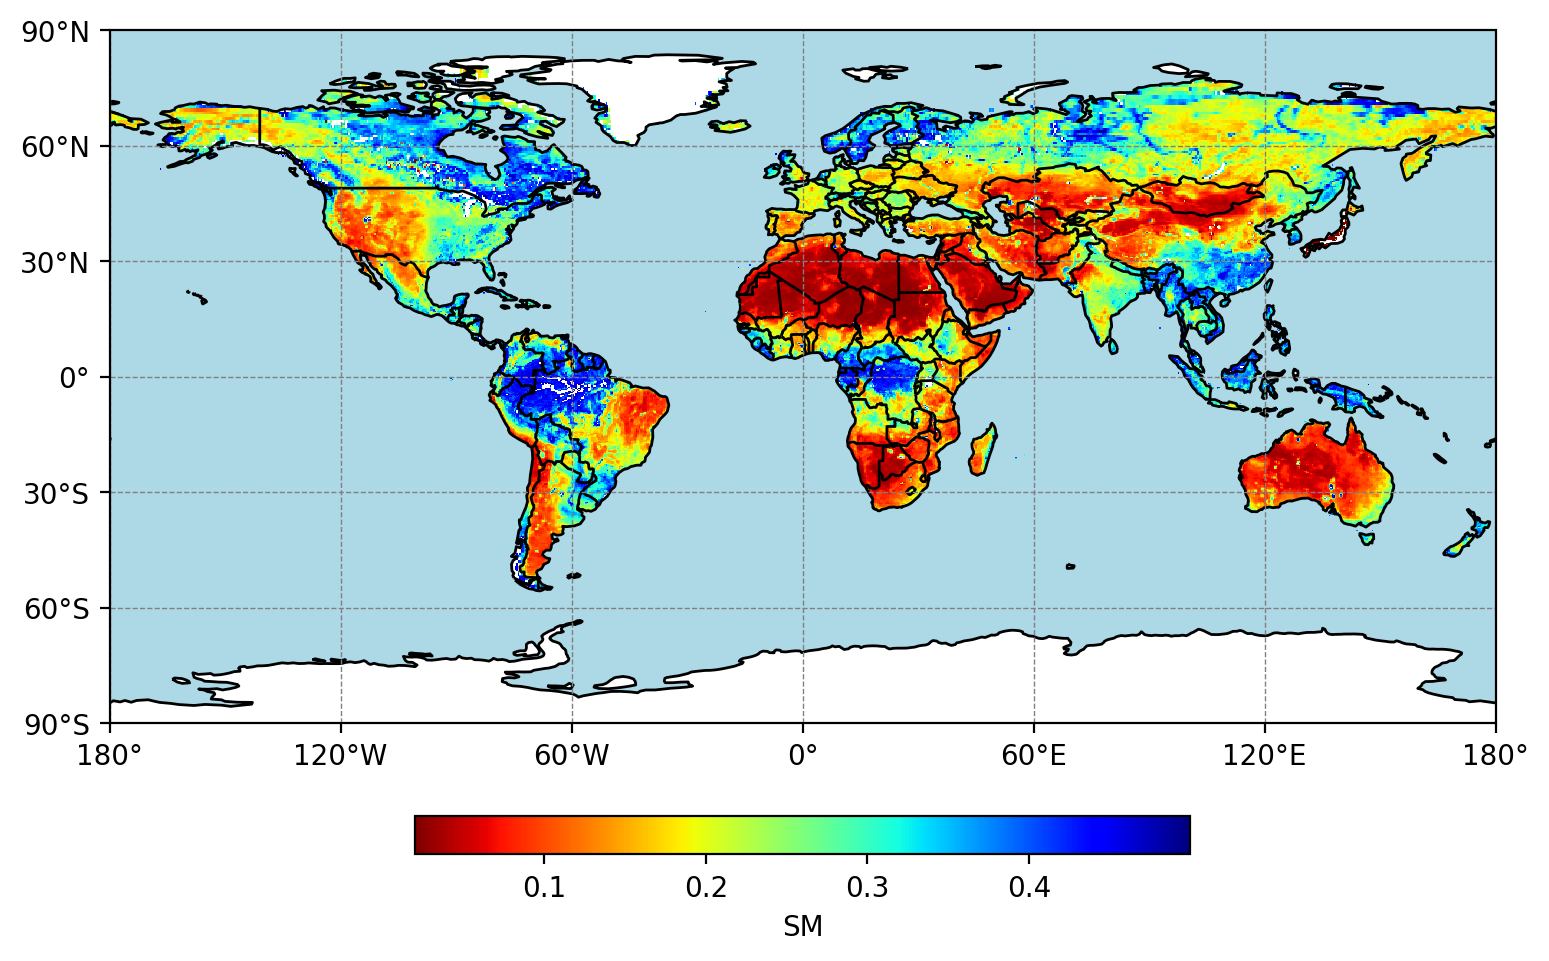

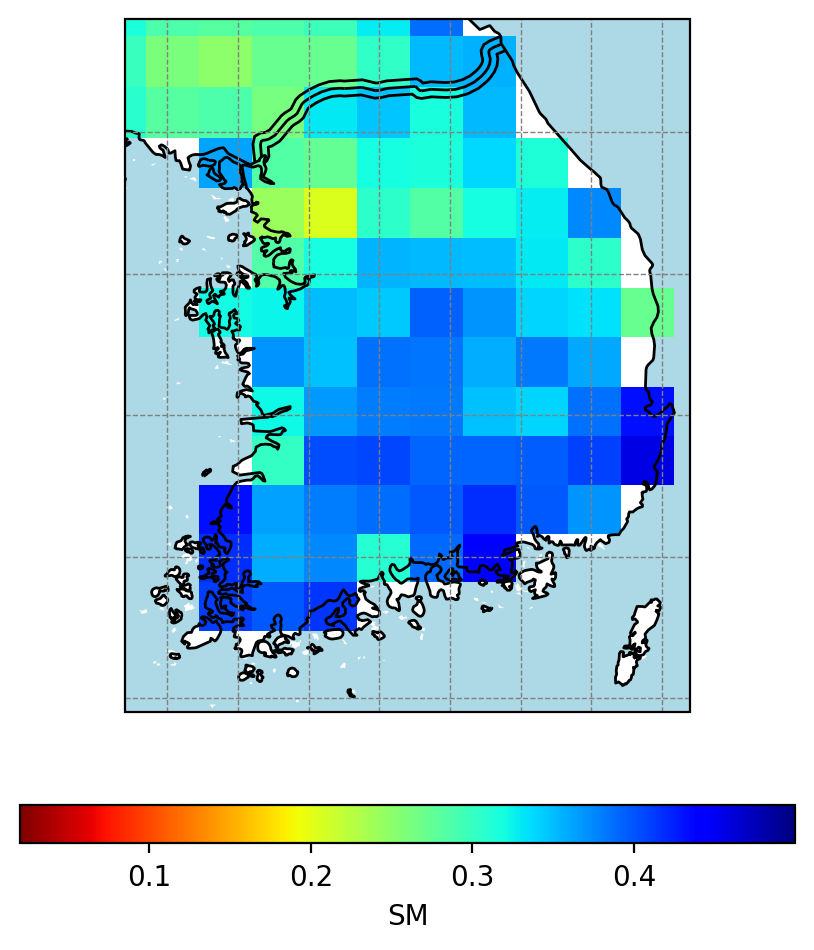

(<Figure size 2000x1200 with 2 Axes>, <GeoAxes: >)

In [33]:
# Display the map with plot_global_map
nanmean_SMAP_SM_AM = np.nanmean(SMAP_SM_AM, axis=2)
target = nanmean_SMAP_SM_AM
Plot.plot_global_map(longitude, latitude, target, 'SMAP SM', np.nanmin(target), np.nanmax(target), 'jet_r')
 
# Display the map with plot_map
bound = [125.7, 129.7, 33.9, 38.8] # entire Korea
#bound = [126.73, 126.95, 35.17, 35.37] # Gwangju
Plot.plot_map(longitude, latitude, target, 'SMAP SM', np.nanmin(target), np.nanmax(target), 'jet_r', bound)

# 2. Import and save SMOS_IC SM

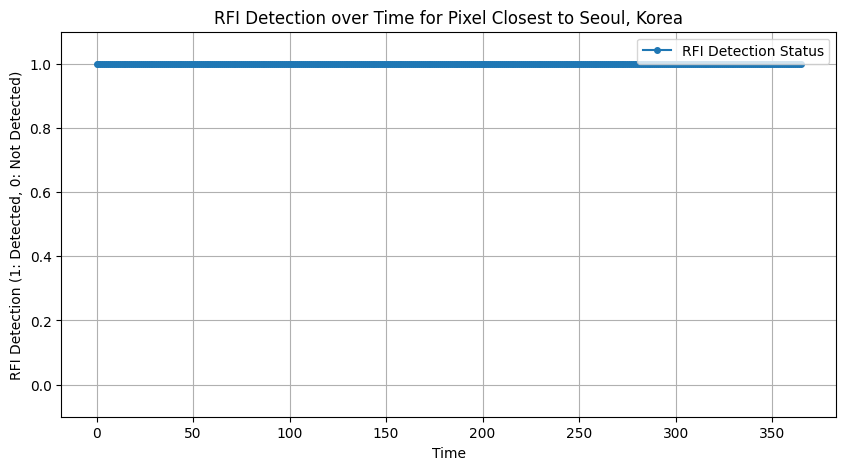

In [67]:
# time-series analysis
# RFI example
seoul_coords = (126.9780, 37.5665)
gist_coords = (126.8394, 35.2276)

rfi_flag_mask = 4  # Replace with the actual mask value for RFI detection
nan_placeholder = -1  # An integer placeholder for NaN values

# Find the closest pixel to Seoul
closest_pixel_index = Data.find_closest_index(longitude, latitude, seoul_coords)
#closest_pixel_index = Data.find_closest_index(longitude, latitude, gist_coords)

# Extract the time series of SMAP_tb4_flag values for the closest pixel
tb4_flag_timeseries = SMAP_tb4_flag_AM[closest_pixel_index[0], closest_pixel_index[1], :]

# Replace NaN values with the placeholder, and ensure data is an integer type
tb4_flag_timeseries_nonan = np.nan_to_num(tb4_flag_timeseries, nan=nan_placeholder).astype(np.int64)

# Initialize rfi_detected array with zeros (no RFI detected by default)
rfi_detected = np.zeros(tb4_flag_timeseries_nonan.shape, dtype=float)

# Check if RFI is detected (bitwise operation), and mark it as 1 in rfi_detected
rfi_detected[(tb4_flag_timeseries_nonan & rfi_flag_mask) == rfi_flag_mask] = 1

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(rfi_detected, label='RFI Detection Status', linestyle='-', marker='o', markersize=4)
plt.xlabel('Time')
plt.ylabel('RFI Detection (1: Detected, 0: Not Detected)')
plt.title(f'RFI Detection over Time for Pixel Closest to Seoul, Korea')
plt.legend()
plt.grid(True)
plt.ylim(-0.1, 1.1)  # Set y-axis limits to make peaks more visible
plt.show()

In [69]:
# Run this line if there is only tar files.
SMOS_data_dir = os.path.join(cpuserver_data_FP, 'SMOS_IC')

#for year in [2015, 2022]:
#    hSMOS_IC.extract_tgz_files(root_dir, year)

In [71]:
path_list = ['A', 'D']
for year in range(2022, 2023): 
    for path in path_list:
        print(year, path)
        directory = os.path.join(SMOS_data_dir, path, str(year))
        file_list, data_doy = hSMOS_IC.extract_filelist_doy(directory)

        # Import Variables
        SMOS_SM, longitude, latitude = hSMOS_IC.create_array_from_nc(file_list, data_doy, year, 'Soil_Moisture')
        SMOS_SM[SMOS_SM<=0] = np.nan
        SMOS_RFI = hSMOS_IC.create_array_from_nc(file_list, data_doy, year, 'Rfi_Prob')[0]
        SMOS_SF  = hSMOS_IC.create_array_from_nc(file_list, data_doy, year, 'Science_Flags')[0]

        # Create a NetCDF file
        path_time = 'am' if path == 'A' else 'pm'
        
        file_name = f'SMOS_IC_{year}_{path_time}.nc'
        nc_file = os.path.join(nc_save_dir, file_name)
                     
        #hSMOS_IC.create_netcdf_file(nc_file, latitude, longitude, SMOS_SM, SMOS_RFI, SMOS_SF)
        #print(f"NetCDF file created: {nc_file}")

2022 A
2022 D


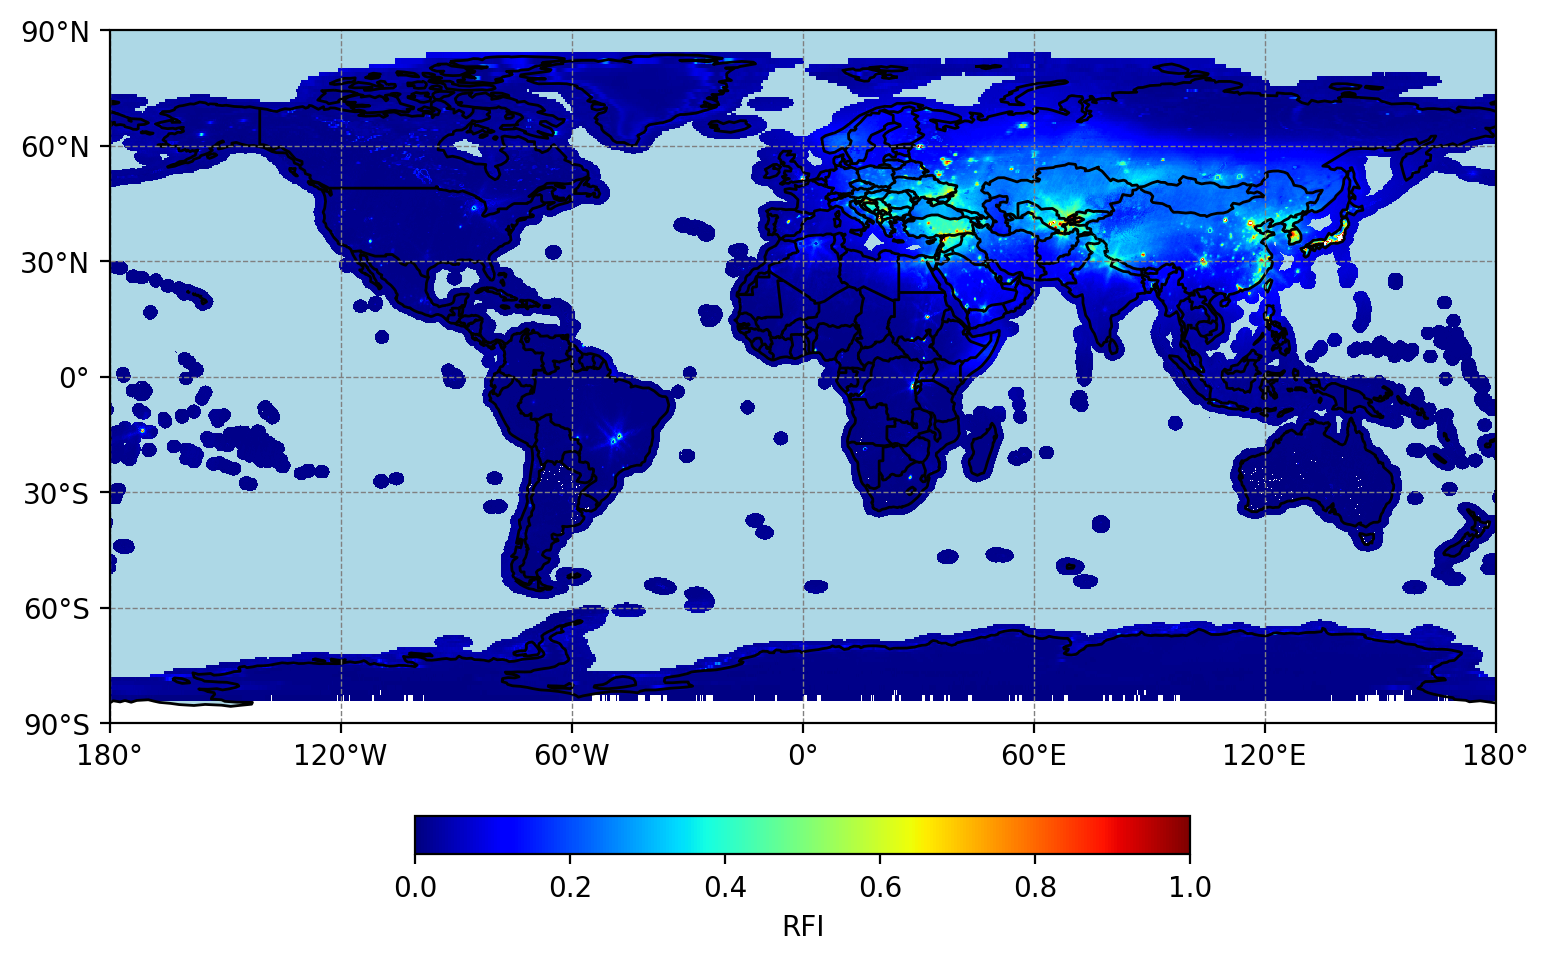

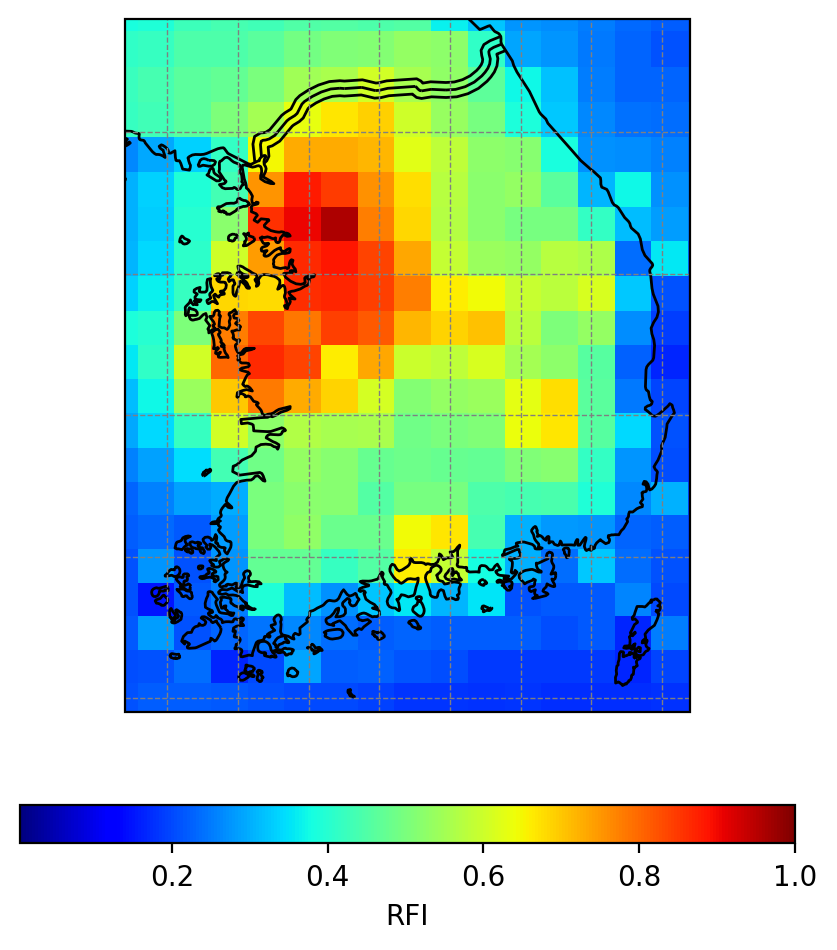

(<Figure size 2000x1200 with 2 Axes>, <GeoAxes: >)

In [73]:
# Display the map with plot_global_map
nanmean_SMOS_SM  = np.nanmean(SMOS_SM, axis=2)
nanmean_SMOS_RFI = np.nanmean(SMOS_RFI, axis=2)
target = nanmean_SMOS_RFI
Plot.plot_global_map(longitude, latitude, target, 'SMOS RFI', 0, 1, 'jet')

# Display the map with plot_map
bound = [125.7, 129.7, 33.9, 38.8] # entire Korea
#bound = [126.73, 126.95, 35.17, 35.37] # Gwangju
Plot.plot_map(longitude, latitude, target, 'SMOS RFI', np.nanmin(target), np.nanmax(target), 'jet', bound)

# 3. Import ASCAT from mat files

In [77]:
#root_dir = cpuserver_data_FP+'/mat_files/ASCAT_h119_120/'
ASCAT_data_dir = os.path.join(cpuserver_data_FP, 'mat_files/ASCAT_h119_120/')

for year in range(2022, 2023):
    path_list = ['am']#, 'pm']
    for path in path_list:
        mat_file = ASCAT_data_dir + str(year) + '_ASCAT_SM_' + path + '_QC.mat'
        ASCAT_SM, latitude, longitude = hASCAT_TUW.load_mat_file(mat_file, path)
        #file_name = 'ASCAT_TUW_'+str(year)+'_'+path+'.nc'
        #nc_file = os.path.join(nc_save_dir, file_name)
        #hASCAT_TUW.create_netcdf_file(nc_file, latitude, longitude, ASCAT_SM)

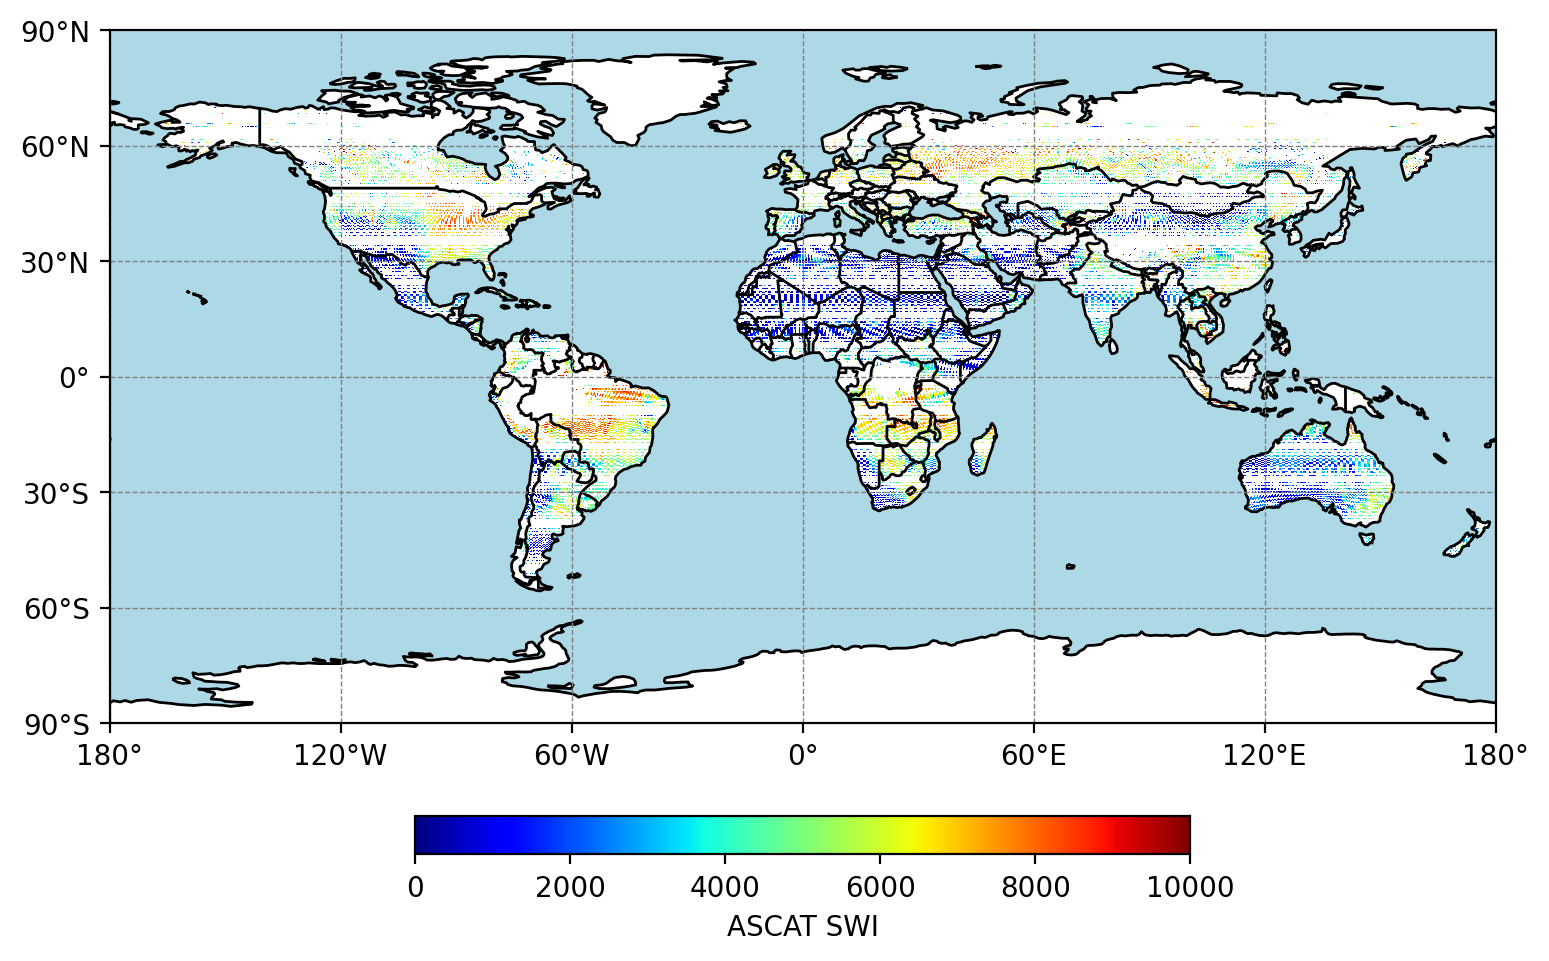

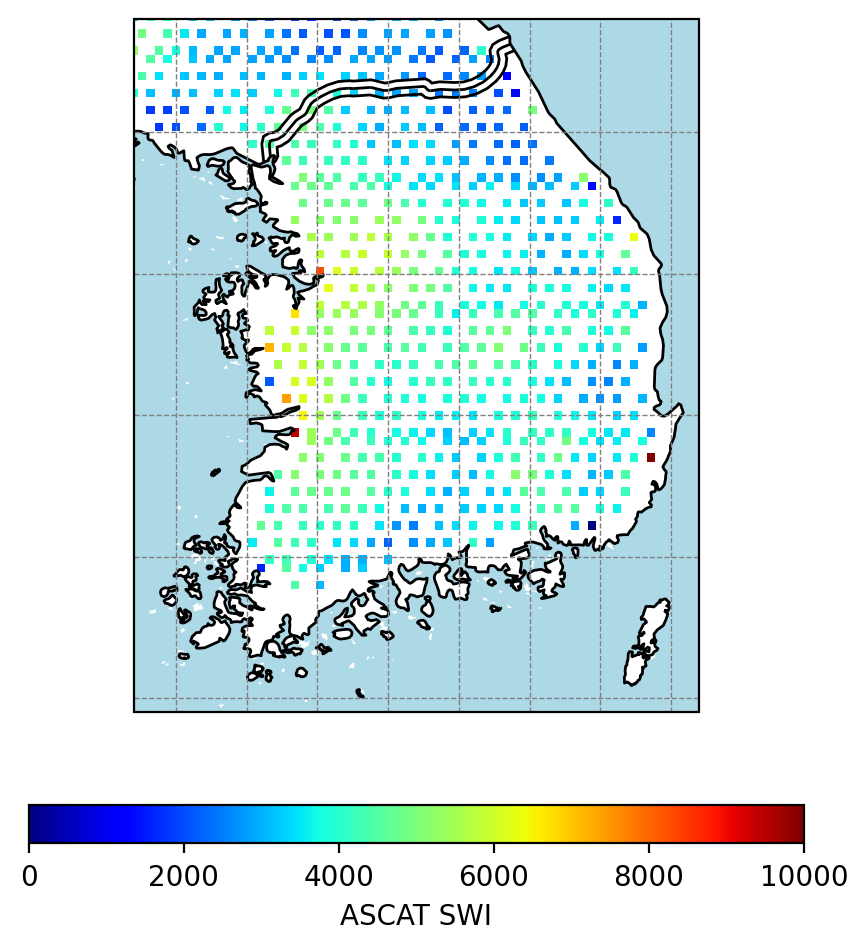

(<Figure size 2000x1200 with 2 Axes>, <GeoAxes: >)

In [80]:
# Display the map with plot_global_map
nanmean_ASCAT_SM = np.nanmean(ASCAT_SM, axis=2)
target = nanmean_ASCAT_SM
Plot.plot_global_map(longitude, latitude, target, 'ASCAT SWI', 0, 10000, 'jet')

# Display the map with plot_map
bound = [125.7, 129.7, 33.9, 38.8] # entire Korea
#bound = [126.73, 126.95, 35.17, 35.37] # Gwangju
Plot.plot_map(longitude, latitude, target, 'ASCAT SWI', np.nanmin(target), np.nanmax(target), 'jet', bound)

## 4. Resampling

### 4.1. Load the domain lat/lon

In [114]:
# Resample SMOS / ASCAT data into SMAP EASE2 grid
mission_product = 'SPL3SMP.008'
domain_lon, domain_lat = hSMAP.get_e2grid(cpuserver_data_FP, mission_product)

# Resample SMOS / ASCAT / SMAP data into land surface model grid
#domain_nc_file = base_FP+'/Lab/2023_DA_TCA/libs/lis_input_noah33.nc'
#nc_data = netCDF4.Dataset(domain_nc_file)
#domain_lat = np.flipud(nc_data.variables['lat'][:]).data
#domain_lon = np.flipud(nc_data.variables['lon'][:]).data
#nc_data.close()

In [115]:
domain_lat.shape

(406, 964)

### 4.2. Resample SMOS-IC data

In [116]:
for year in range(2022, 2023):
    path_list = ['am']#, 'pm']
    
    for path in path_list:
        # resample SMOS into the doamin size
        nc_file  = nc_save_dir+'/SMOS_IC_'+str(year)+'_'+path+'.nc'
        nc_data  = netCDF4.Dataset(nc_file)
        SMOS_SM  = nc_data.variables['SMOS_SM'][:].data
        #SMOS_RFI = nc_data.variables['SMOS_RFI'][:].data
        #SMOS_SF  = nc_data.variables['SMOS_SF'][:].data
        SMOS_lat = nc_data.variables['latitude'][:].data
        SMOS_lon = nc_data.variables['longitude'][:].data
        nc_data.close()
    
        Resampled_SMOS_SM  = Data.Resampling_forloop(domain_lat, domain_lon, SMOS_lat, SMOS_lon, SMOS_SM)
        #Resampled_SMOS_RFI = Data.Resampling_forloop(domain_lat, domain_lon, SMOS_lat, SMOS_lon, SMOS_RFI)
        #Resampled_SMOS_SF  = Data.Resampling_parallel(domain_lat, domain_lon, SMOS_lat, SMOS_lon, SMOS_SF, 'nearest', 'mode',3) #too slow
        
        #We may need to apply RFI/SF first and resample SM
        #file_name = 'SMOS_IC_'+str(year)+'_'+path+'_R_'+mission_product+'.nc'
        #nc_file = nc_save_dir+'/'+file_name
        #hSMOS_IC.create_netcdf_file(nc_file, domain_lat, domain_lon, Resampled_SMOS_SM, Resampled_SMOS_RFI)

KeyboardInterrupt: 

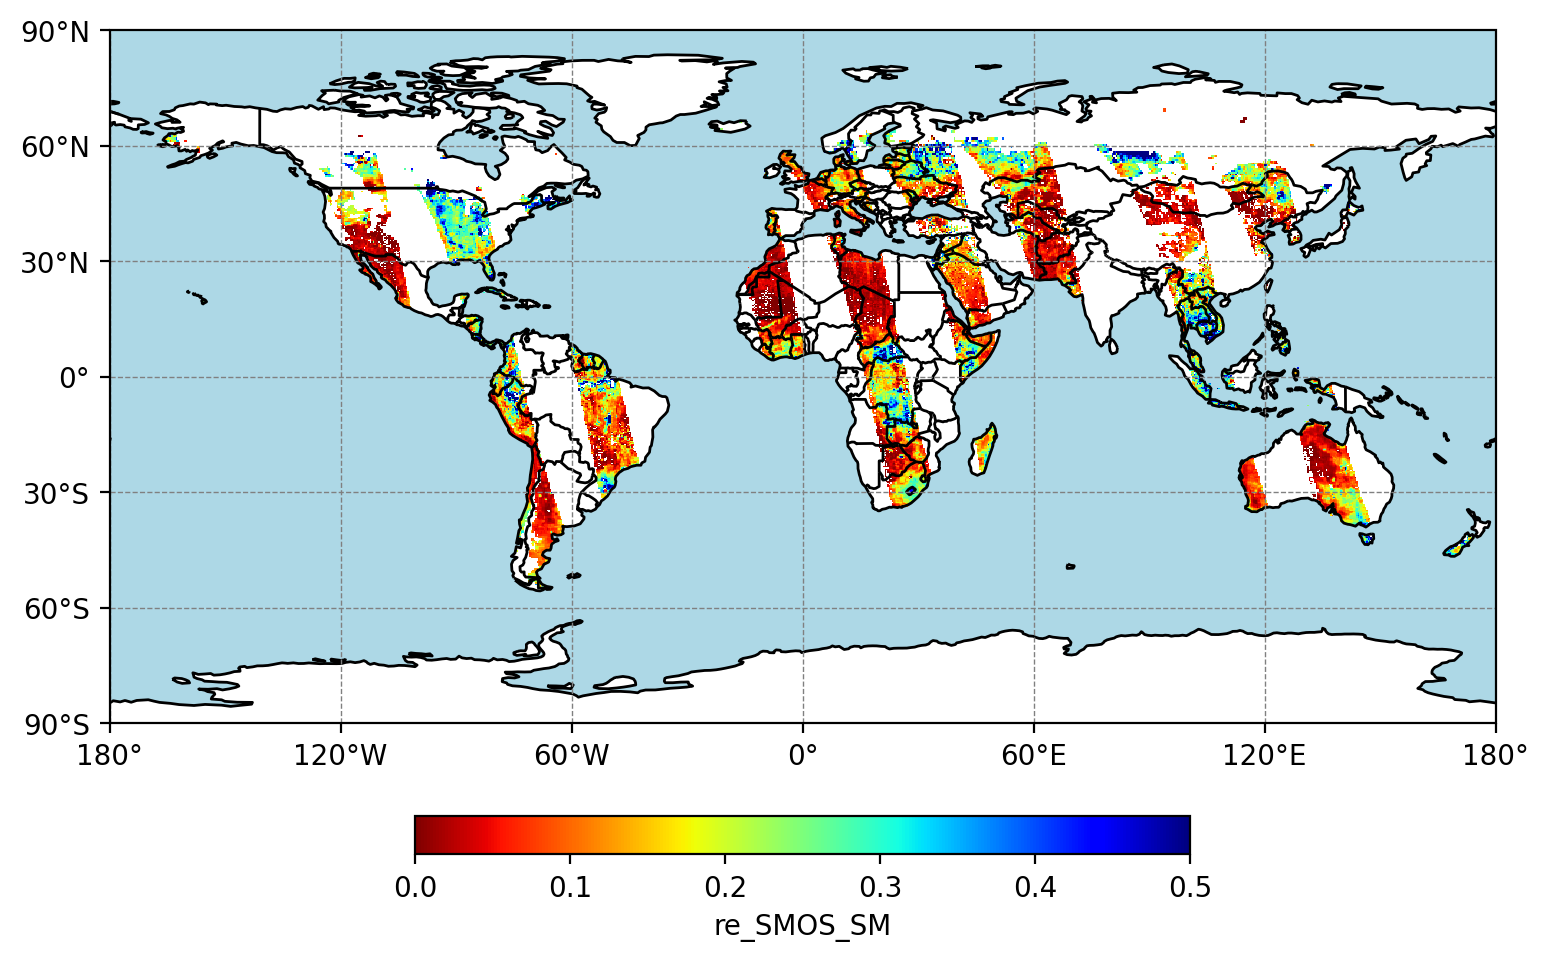

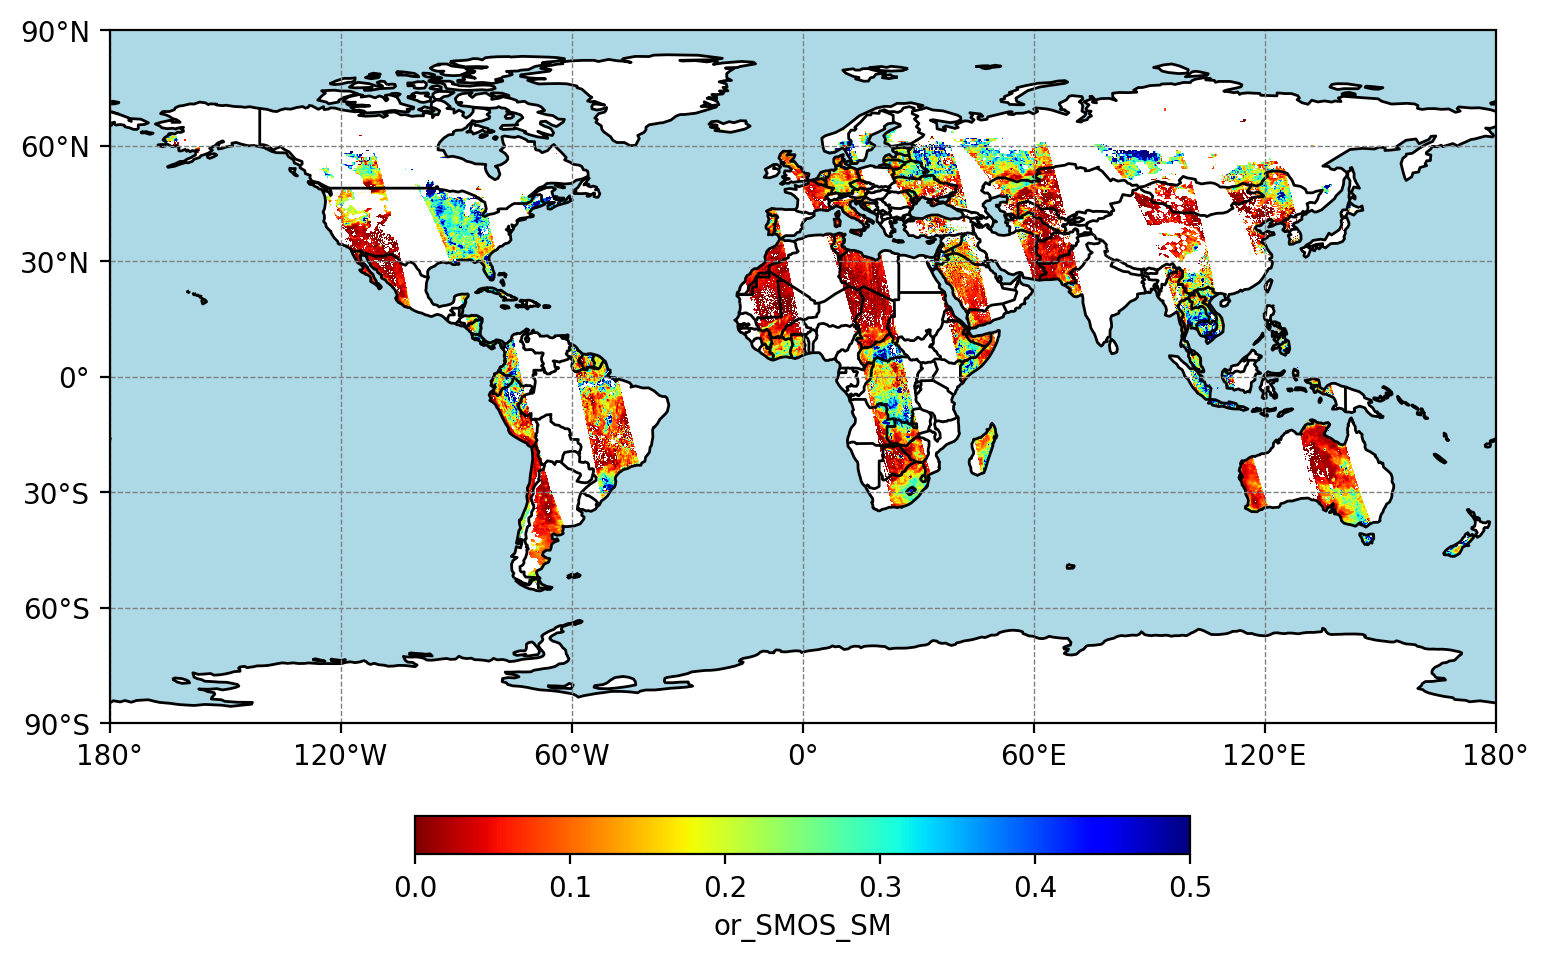

In [91]:
# Check the resampled data
doy = 121
r_smos = Resampled_SMOS_SM[:,:,doy]
Plot.plot_global_map(domain_lon, domain_lat, r_smos, 're_SMOS_SM', 0, 0.5, 'jet_r')
smos = SMOS_SM[:,:,doy]
Plot.plot_global_map(SMOS_lon, SMOS_lat, smos, 'or_SMOS_SM', 0, 0.5, 'jet_r')

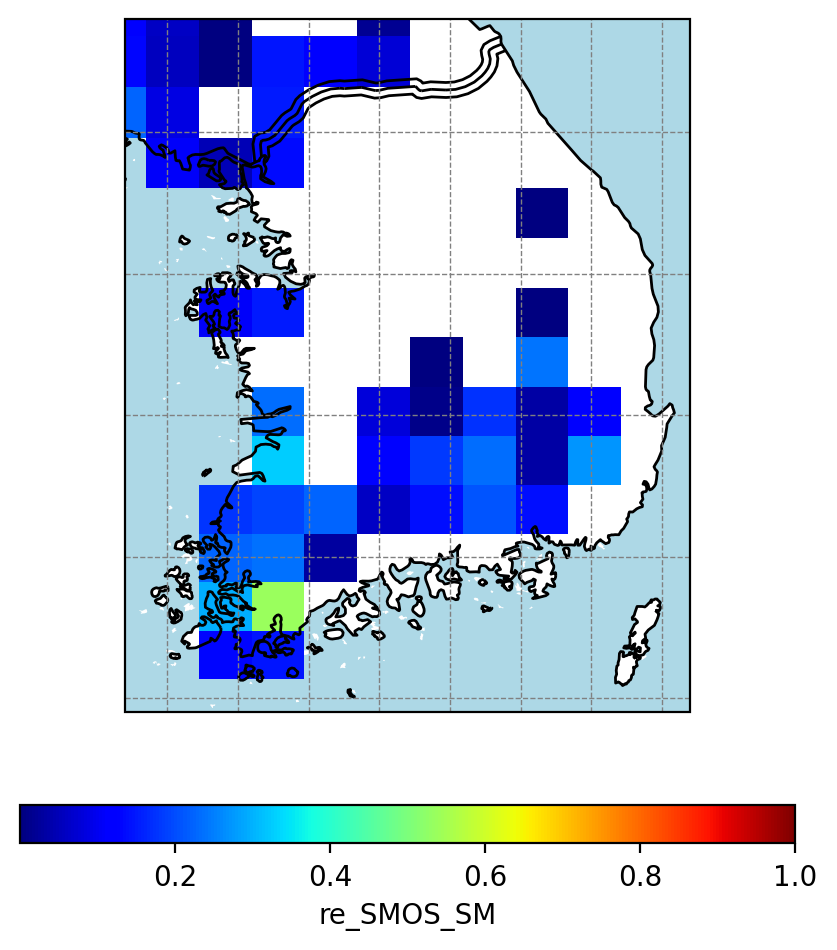

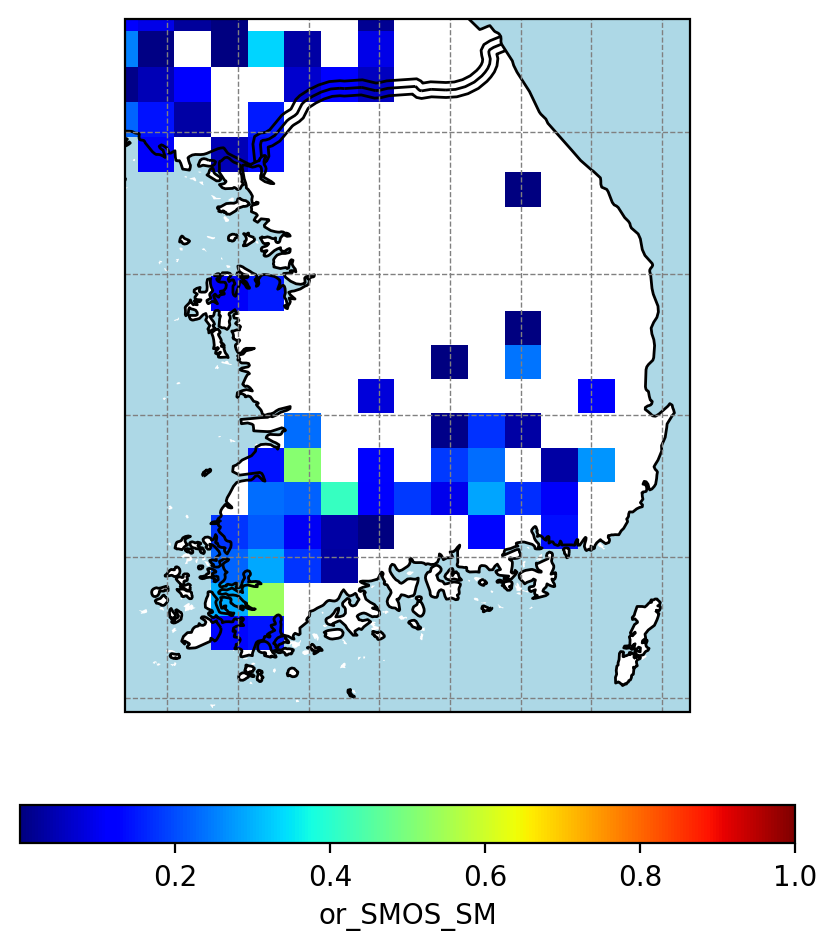

(<Figure size 2000x1200 with 2 Axes>, <GeoAxes: >)

In [92]:
# Display the map with plot_map
bound = [125.7, 129.7, 33.9, 38.8] # entire Korea
#bound = [126.73, 126.95, 35.17, 35.37] # Gwangju
Plot.plot_map(domain_lon, domain_lat, r_smos, 're_SMOS_SM', np.nanmin(r_smos), np.nanmax(r_smos), 'jet', bound)
Plot.plot_map(SMOS_lon, SMOS_lat, smos, 'or_SMOS_SM', np.nanmin(smos), np.nanmax(smos), 'jet', bound)

### 4.3. Resample ASCAT

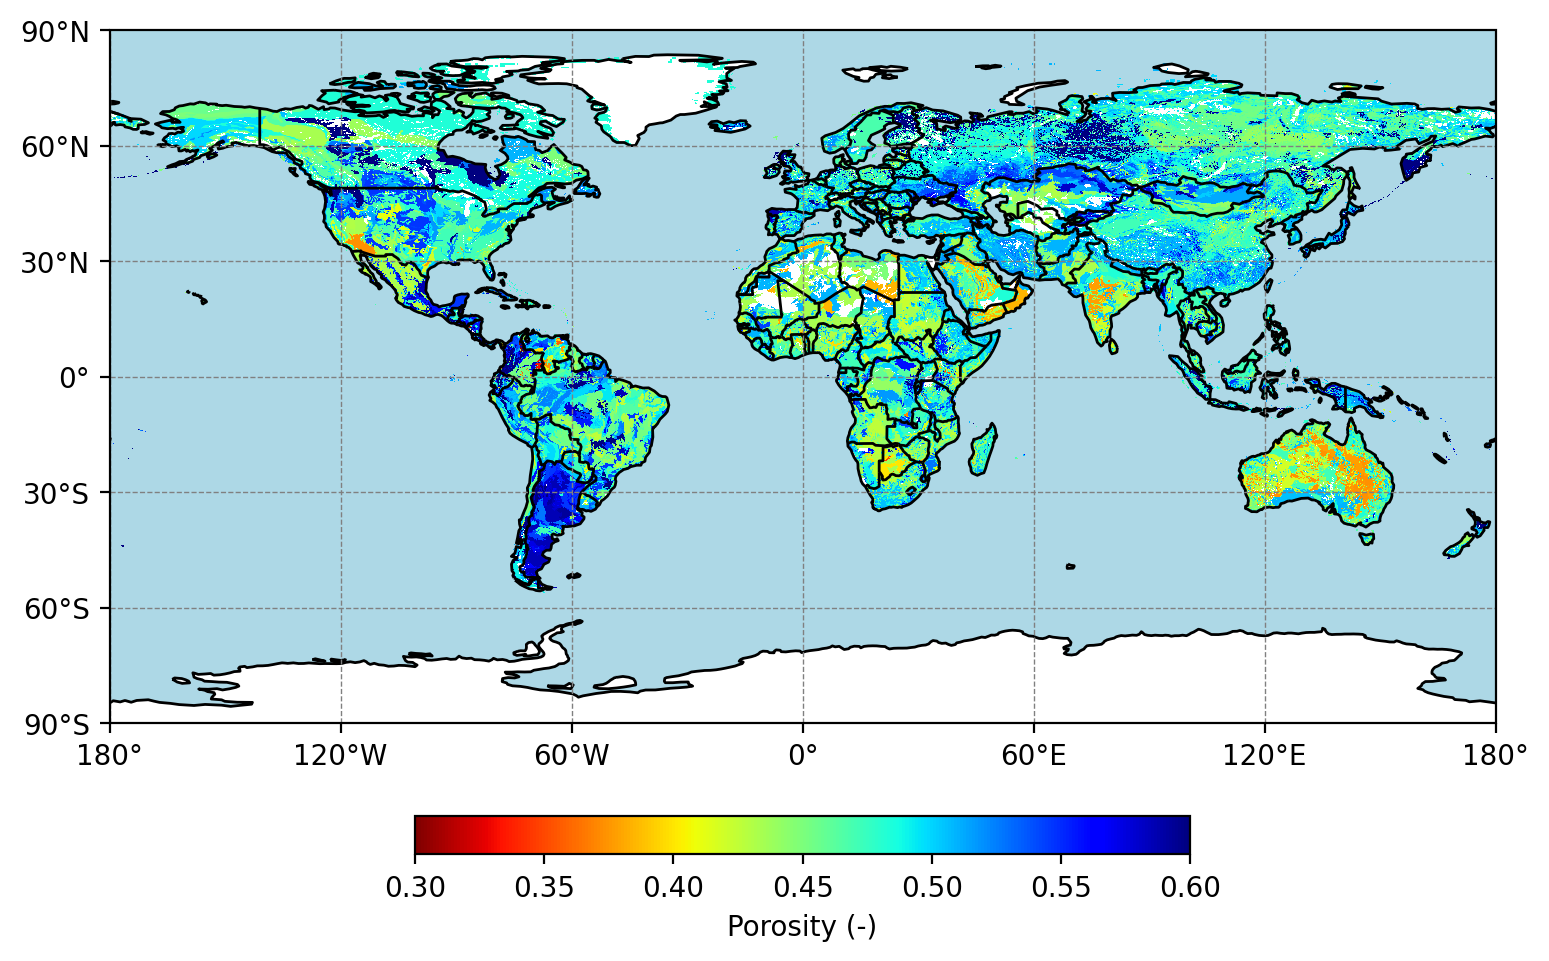

In [93]:
#import porosity
porosity_EASE9_mat_file  = cpuserver_data_FP+'/mat_files/soil_climate_etc/world_PORO_EASE_009.mat'
ease_grid_EASE9_mat_file = cpuserver_data_FP+'/mat_files/ease_grid_files/ease_lat_lon_9km.mat'

poro_EASE9 = hASCAT_TUW.load_porosity_mat(porosity_EASE9_mat_file)['PORO']
lat_EASE9 = hASCAT_TUW.load_porosity_mat(ease_grid_EASE9_mat_file)['ease_lat_9km']
lon_EASE9 = hASCAT_TUW.load_porosity_mat(ease_grid_EASE9_mat_file)['ease_lon_9km']

Plot.plot_global_map(lon_EASE9, lat_EASE9, poro_EASE9, 'Porosity (-)', 0.3, 0.6, 'jet_r')

In [94]:
# Resample SM
for year in range(2022, 2023):
    path_list = ['am']#, 'pm']
    for path in path_list:
        # resample ASCAT into the doamin size
        nc_file  = nc_save_dir+'/ASCAT_TUW_'+str(year)+'_'+path+'.nc'
        nc_data  = netCDF4.Dataset(nc_file)
        ASCAT_SM  = nc_data.variables['ASCAT_SM'][:].data
        ASCAT_lat = nc_data.variables['latitude'][:].data
        ASCAT_lon = nc_data.variables['longitude'][:].data
        nc_data.close()
        print('data_loaded')
        Resampled_ASCAT_SM  = Data.Resampling_forloop(domain_lat, domain_lon, ASCAT_lat, ASCAT_lon, ASCAT_SM, 'nearest','mean', 1)
        
        #file_name = 'ASCAT_IC_'+str(year)+'_'+path+'_R_'+mission_product+'.nc'
        #nc_file = nc_save_dir+'/'+file_name
        #hASCAT_TUW.create_netcdf_file(nc_file, domain_lat, domain_lon, Resampled_ASCAT_SM)

data_loaded


100%|█████████████████████████████████████████| 365/365 [00:43<00:00,  8.39it/s]


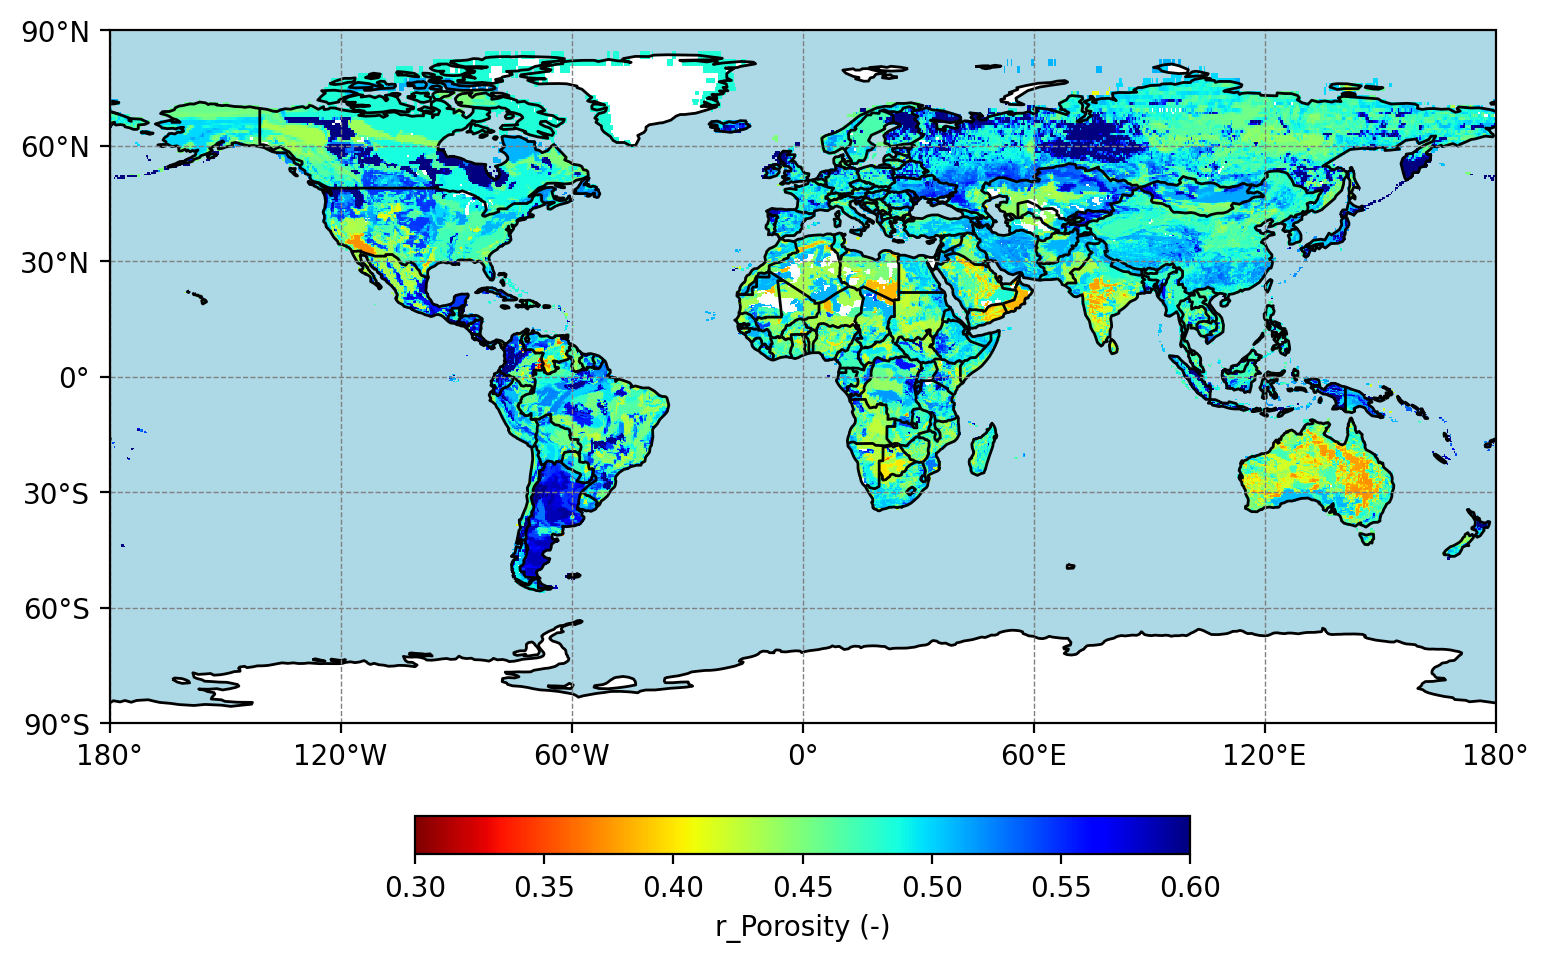

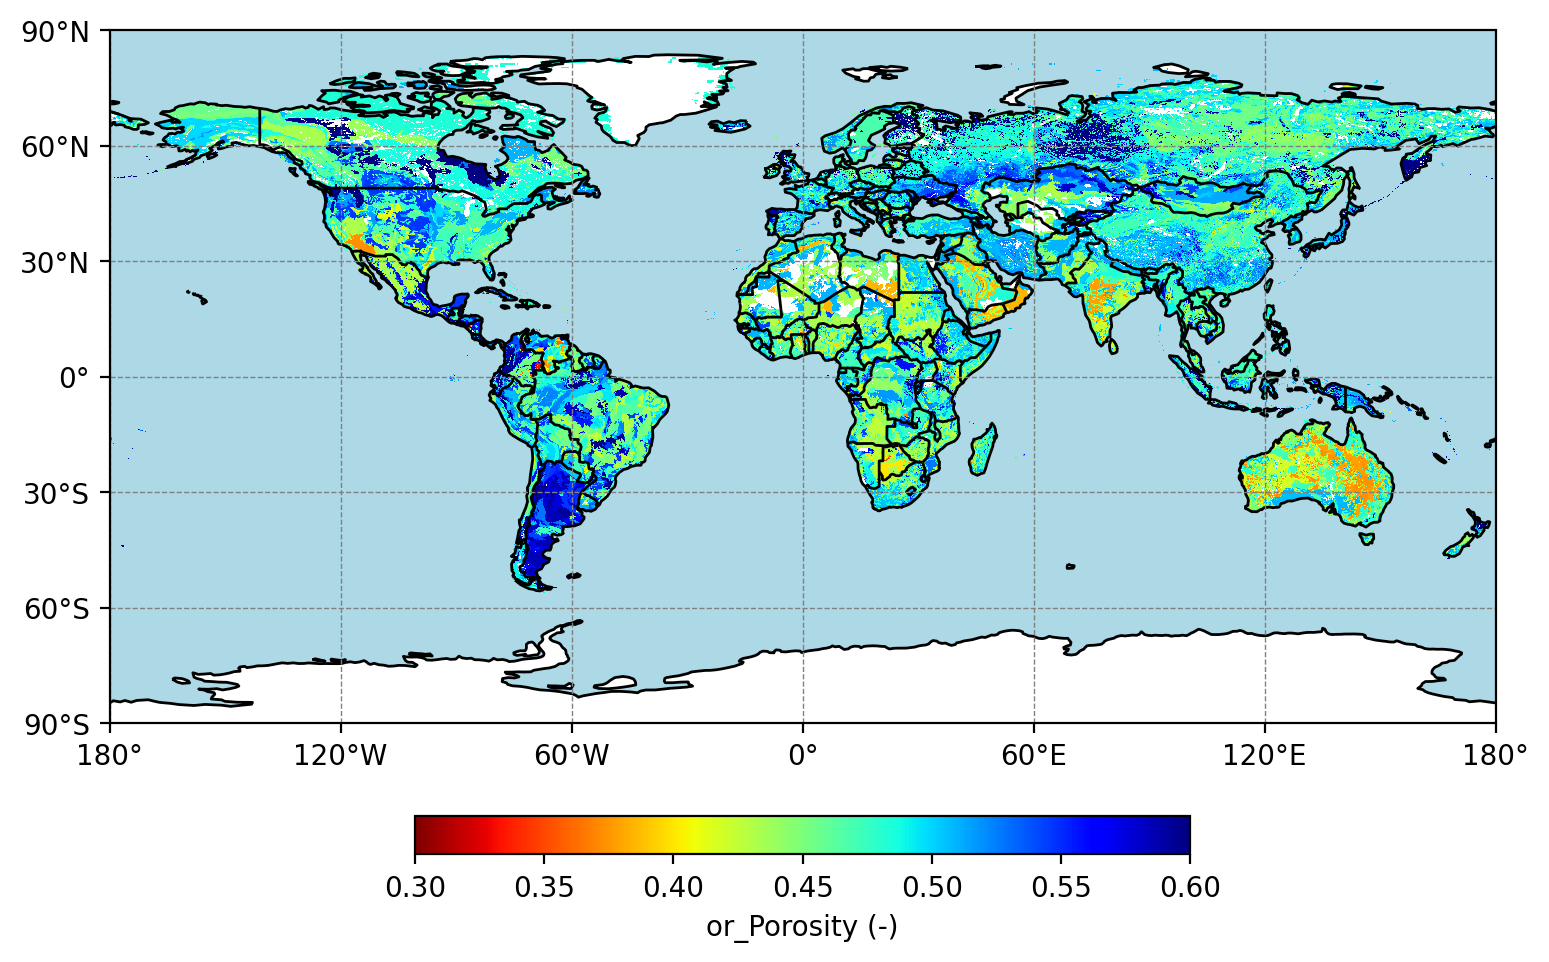

In [95]:
# Resample porosity
importlib.reload(hASCAT_TUW)
Resampled_poro = Data.Resampling(domain_lat, domain_lon, lat_EASE9, lon_EASE9, poro_EASE9, sampling_method='nearest', agg_method='mean', mag_factor=2) 
nc_file  = nc_save_dir+'/PORO_R_'+mission_product+'.nc'
hASCAT_TUW.create_netcdf_file(nc_file, domain_lat, domain_lon, Resampled_poro, 'Porosity')

r_poro = Resampled_poro
Plot.plot_global_map(domain_lon, domain_lat, r_poro, 'r_Porosity (-)', 0.3, 0.6, 'jet_r')
Plot.plot_global_map(lon_EASE9, lat_EASE9, poro_EASE9, 'or_Porosity (-)', 0.3, 0.6, 'jet_r')

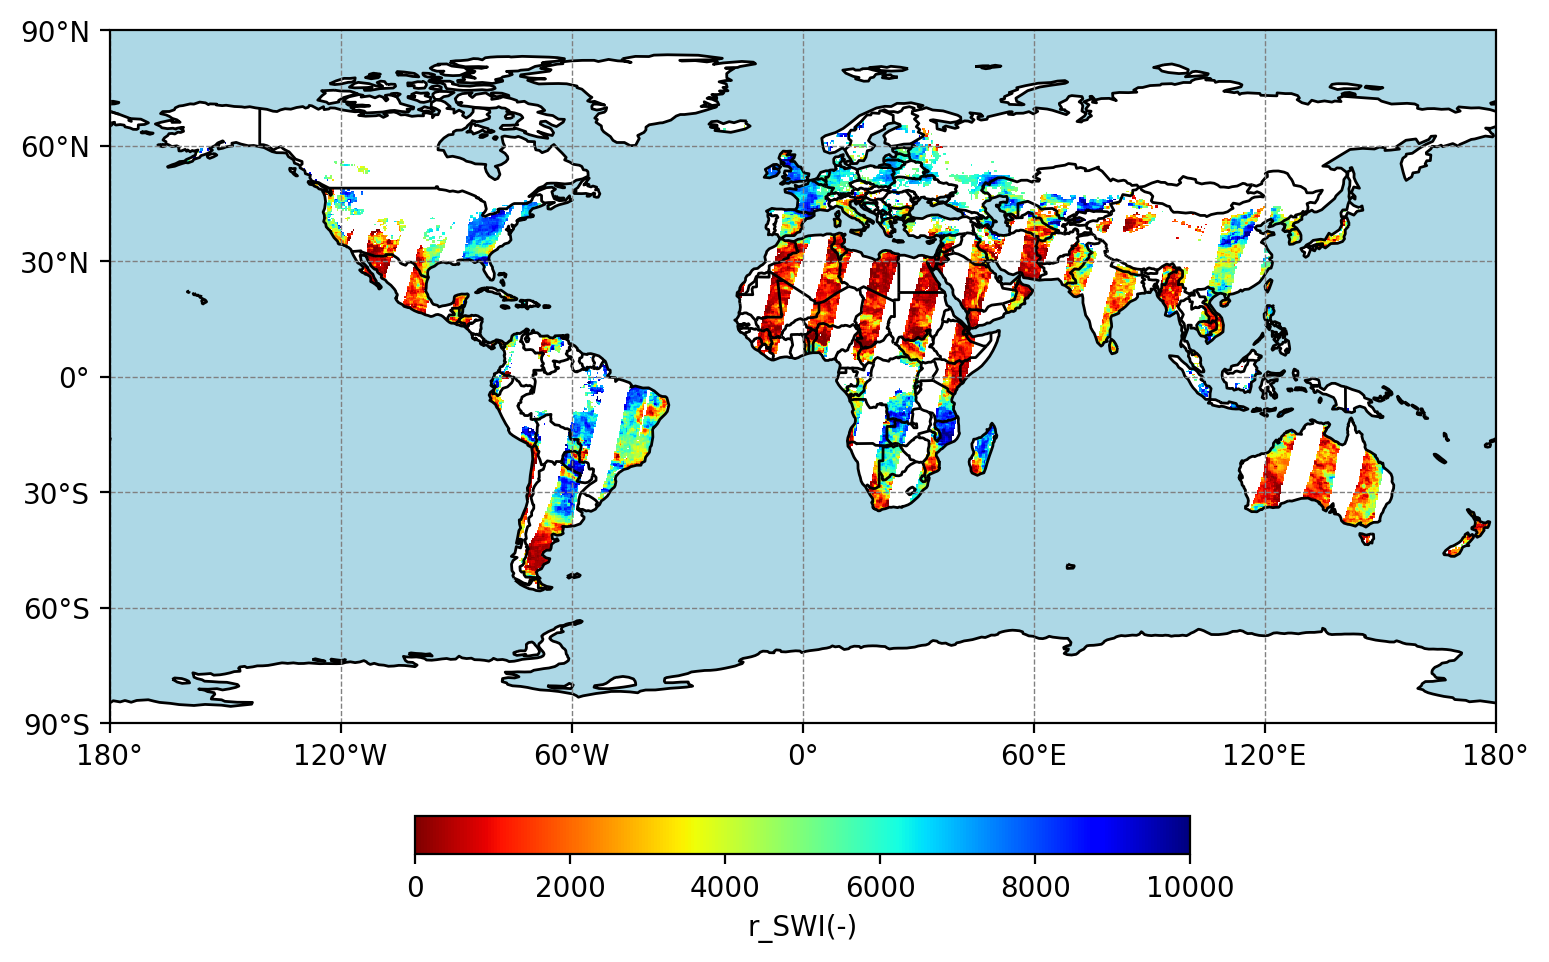

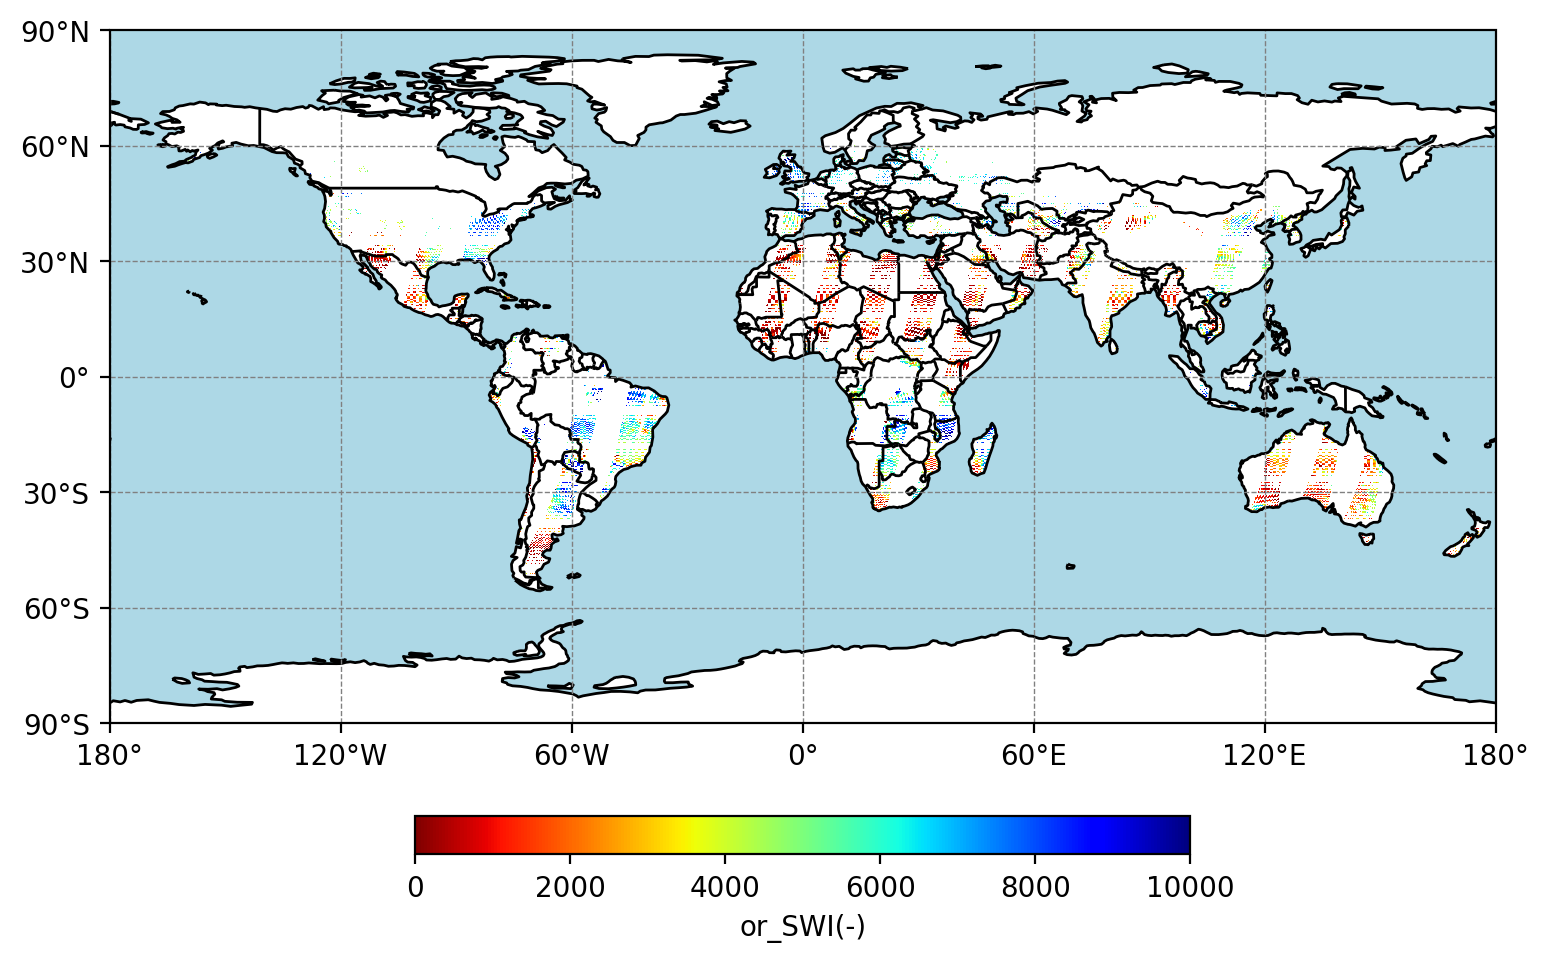

In [100]:
# Check if Resampled ASCAT data
doy = 70
r_ascat = Resampled_ASCAT_SM[:,:,doy]
Plot.plot_global_map(domain_lon, domain_lat, r_ascat, 'r_SWI(-)', 0, 10000, 'jet_r')
ascat = ASCAT_SM[:,:,doy]
Plot.plot_global_map(ASCAT_lon, ASCAT_lat, ascat, 'or_SWI(-)', 0, 10000, 'jet_r')

#np.nanmax(r_ascat)

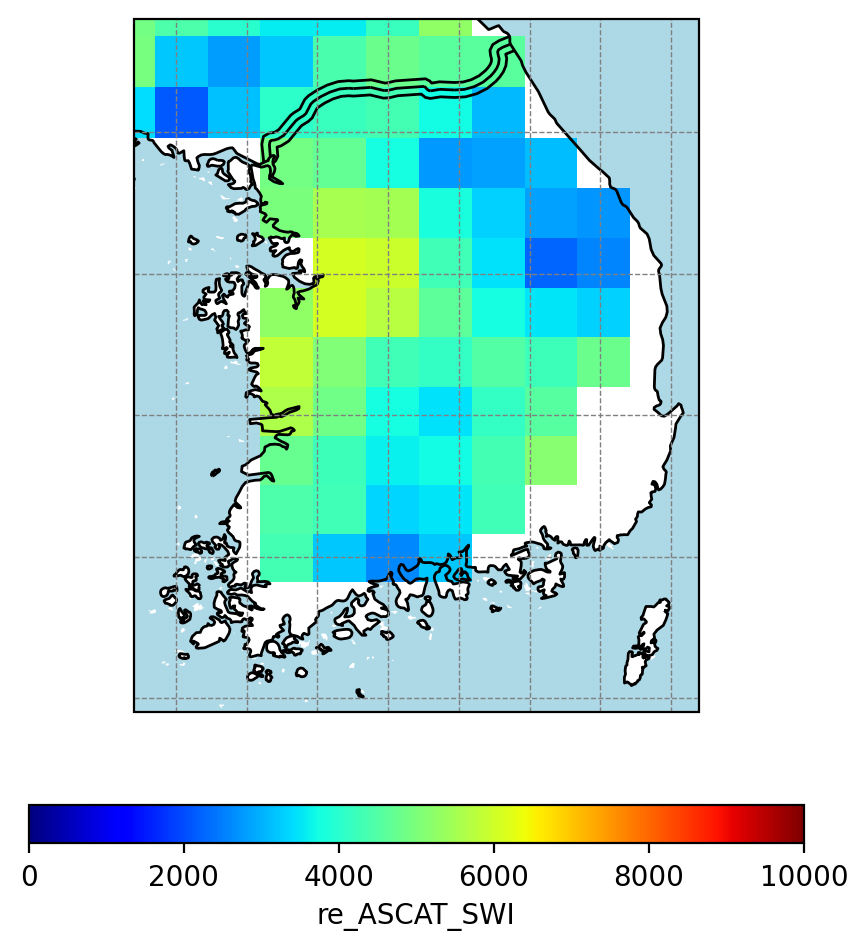

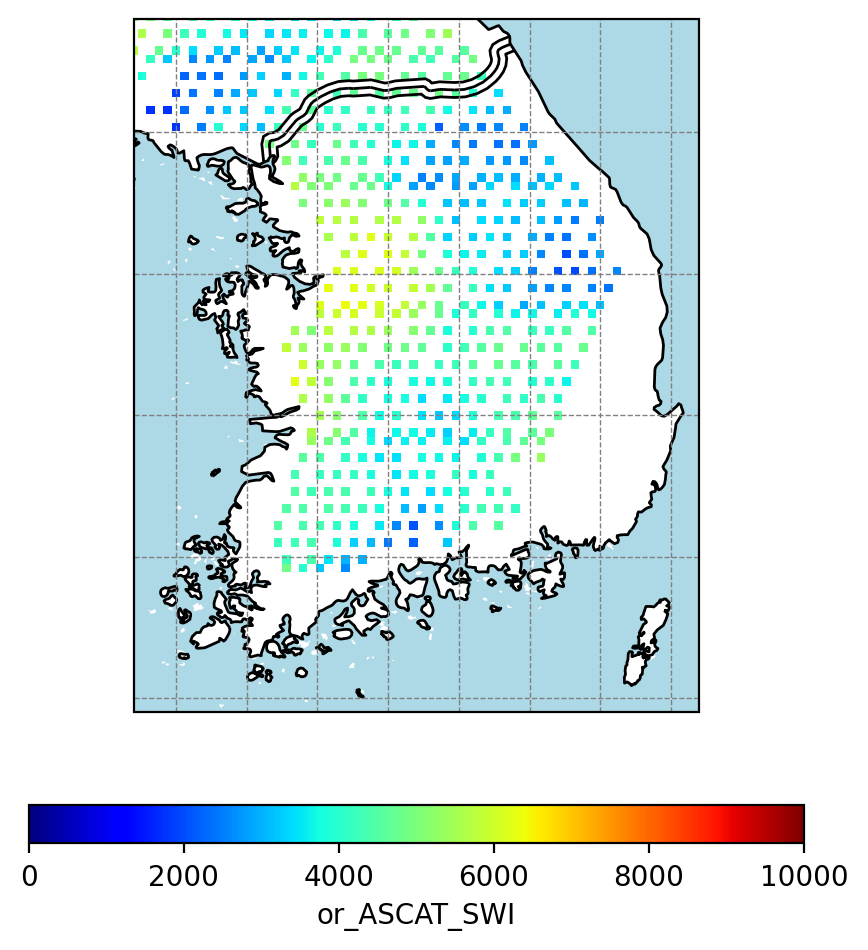

(<Figure size 2000x1200 with 2 Axes>, <GeoAxes: >)

In [101]:
# Display the map with plot_map
bound = [125.7, 129.7, 33.9, 38.8] # entire Korea
#bound = [126.73, 126.95, 35.17, 35.37] # Gwangju
Plot.plot_map(domain_lon, domain_lat, r_ascat, 're_ASCAT_SWI', np.nanmin(r_ascat), np.nanmax(r_ascat), 'jet', bound)
Plot.plot_map(ASCAT_lon, ASCAT_lat, ascat, 'or_ASCAT_SWI', np.nanmin(ascat), np.nanmax(ascat), 'jet', bound)